# Human wall distance detection
This program finds the distance between a human and the furtherest wall in a corridor using a depth image. The program will also output which side the furtherest wall is on.  

## Environment
The python script is written with Python 3.6.5 and uses the following libraries.
* Numpy 1.15.4  
* Opencv 4.0.0    
* Scipy 1.2.1    

## Files
* **[find_clearance.py](utils.py) :** Main executable python script
* **[utils.py](utils.py) :** Functions used in the main script
* **[result_showcase.ipynb](result_showcase.ipynb) :** Jupyter notebook that showcases the result at each step 

## Approach
The program tackles the clearance detection task using the following steps: 
1. Reconstruct world frame coordinates from depth image pixels  
Using the range of vertical and horizontal field of view data from the camera, assuming each pixel is at the same size and no lens distortion, we can calculate the corresponding coordinates of each pixel represents in the world frame.   
We set the camera to be the origin in the world frame, x-axis perpendicular to the walls pointing to the right, y-axis parallel to the wall and pointing away from the camera, z-axis pointing upwards perpendicular to the ground.   
We remove points that are too close or too far, and remove the points representing the ground.  


2. Get contours of obstacles in the images  
Using the x y coordinates, we can reconstruct a sudo bird's eye view from the depth image. Assuming the obstable(human) is a cylindar, the obstacle's y value range in the reconstructed bird's eye view image should be approximately half of the real object. We use this to determine the range of y values used in the xy image to find the contours of the obstacle and walls. 


3. Calculate the gap size and make decision  
Once we have the contours of the obstacle and the walls, we calculate the minimum gap on each side of the obstacle. Finally, the program returns the side with the larger gap and the gap size in meters.

## Generalization
Corner Cases:
* The human is too close to the wall and the program cannot distinguish the contour of the human from the wall  
If this is the case, then in the step of finding contours, it is possible for the human bounding box to be the left or right most. The program has already accounted for these cases and should perform correctly.   


* The human is partly connected to the wall (e.g. one arm touching the wall but enough space underneath)
In this program, when selecting the points for finding contours, there is only a low limit for Z values to remove the ground. If we have the information about the robot's height, we can also set a high limit for Z values that we only need to consider the gap size under such height.  


In order to generalize the program, we will look at the assumptions we made in this program: 
* The robot is at the center of the corridor and parallel to the walls  
If the robot is positioned arbitrarily, both location and orientation, we can still calculate the XYZ coordinates from the depth image, but they would be in the camera frame. We then can obtain the world frame coordinates through the pose of the camera wTc in SE(3):  
\begin{equation}
wTc = 
\begin{bmatrix} 
R & p \\
0 & 1 
\end{bmatrix}
\end{equation} 
where R is the orientation and p = [x,y,z] is the location of the robot in the world frame. Then we can obtain the world frame coordinates for each point in the camera frame through:

\begin{equation}
\begin{bmatrix} 
x_W\\
y_W \\
z_W\\
1\\
\end{bmatrix}
=
T
\begin{bmatrix} 
x_B \\
y_B \\
z_B\\
1\\
\end{bmatrix}
\end{equation}

* Ground is flat  
Since the task is detecting human in corridors, if the ground is not flat, we can still assume it is smooth but sloped, we then need to approximate the slope and remove the ground accordingly.  
We can also use pretrained network to identify background and floor for more complicated ground removal cases.  


* There is only one obstacle  
In this program, we assume there is only one human in the depth image and therefore 2 gaps to choose from. This allow us to assume the obstacle has contour closest to the center of the image. When we have multiple obstacles, we need to locate all gaps and the corresponding sizes.  
We can also use a different approach to detect human obstacles. Instead of simply setting the bounding box closest to the center as human and others as walls, we can use pretrained CNN networks to identify humans from walls, then calculate the appropriate gaps between humans and walls.  


# Code

In [1]:
import numpy as np
import cv2
from scipy import stats
from matplotlib import pyplot as plt

## Load Data

In [2]:
depth_img = np.loadtxt('human_corridor_0.txt')

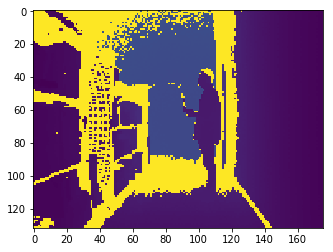

In [3]:
plt.imshow(depth_img)

## Convert to World Frame Coordinates

In [4]:
def get_w_coords(img):
    '''
    The function extract the approximate world frame coordinates of each pixel in the depth image.
    
    The calculation is based on the assuming the camera is at the origin of the world frame, and 
    parallel to the walls on the sides. The camera has 70 degree horizontal field of view, 
    and 50 degree vertical field of view.
    
    Input: 
    img: depth image 
    
    Output: 
    x, y, z: coordinates in world frame (each has dimension same as the depth image)
    '''
    H,L = img.shape
    theta_step = 50/180*np.pi / H
    phi_step = -70/180*np.pi / L
    theta_init = 65 /180 * np.pi # 65 to 115 degree
    phi_init = 125 / 180 * np.pi # 125 to 55 degree
    r = img
    theta = np.zeros(r.shape)
    phi = np.zeros(r.shape)
    for i in range(H):
        for j in range(L):
            theta[i,j] = theta_init + i * theta_step
            phi[i,j] = phi_init + j * phi_step
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [5]:
def process_coords(x,y,z,x_limit = 5,y_limit_h = 5,y_limit_l = 2,ground_limit = 0.2):
    '''
    This function process the coordinates in the world frame so that it discards all points that are not in our
    range of interest and removes the ground.
    
    Input:
    x, y, z: coordinates in world frame
    
    Keyword arguments:
    x_limit: the range of x values accepted (meters)
    y_limit_h, y_limit_l: the range of y values accepted (meters)
    ground_limit: all points below the limit count as ground
    
    Output:
    X,Y,Z: filtered coordinates in the world frame (flattened shape for easy scatterplot)
    '''
    H,L = x.shape
    # reshape x,y,z for scatter plots
    X = x.reshape(L*H)
    Y = y.reshape(L*H)
    Z = z.reshape(L*H)
    
    #use the middle bottom pixel as ground height (plus ground limit)
    ground_height = z[H-1,int(L/2)] + ground_limit
    
    # filter points that are too far and on the ground
    x_idx = np.abs(X) < x_limit
    y_idx = np.logical_and(Y < y_limit_h,Y > y_limit_l)
    z_idx = Z > ground_height
    selected = np.logical_and(np.logical_and(x_idx,y_idx),z_idx)
    
    X_s = X[selected]
    Y_s = Y[selected]
    Z_s = Z[selected]
    return X_s, Y_s, Z_s

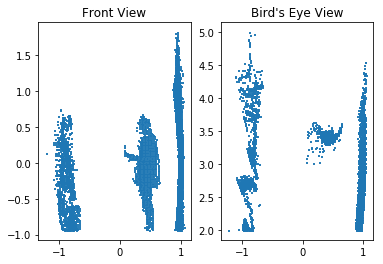

In [6]:
x,y,z = get_w_coords(depth_img)
X,Y,Z = process_coords(x,y,z)

# Plot Scatter Plots
fig, (ax1, ax2) = plt.subplots(1, 2)
# front view
ax1.scatter(X,Z,1,marker="s")
ax1.set_title('Front View')

# bird's eye view
ax2.scatter(X,Y,1,marker="s")
ax2.set_title("Bird's Eye View")

plt.show()

## Bounding Boxes

In [7]:
def get_bin_img(X1,X2,bin1_s = 200,bin2_s = 200):
    '''
    This function produce a binary image based on the binned values from x1 x2 values
    
    Input:
    X1: x1 axis's coordinates of points   
    X2: x2 axis's coordinates of points   
    
    Keyword arguments:
    bin1_s: number of bins for x1 values
    bin2_s: number of bins for x2 values
    
    Output:
    bins: binned image 
    '''
    # get binned values
    binary_bin = stats.binned_statistic_2d(X1, X2, None, 'count', bins=[bin1_s,bin2_s])
    bins = binary_bin.statistic
    # if the bin is occupied, set value to 1, else 0
    bins = bins>0
    return bins

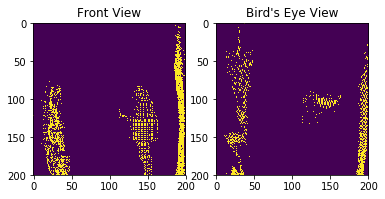

In [8]:
bin_xy = get_bin_img(-Y,X)
bin_xz = get_bin_img(-Z,X)

# Plot Binned images
fig, (ax1, ax2) = plt.subplots(1, 2)
# front view
ax1.imshow(bin_xz)
ax1.set_title('Front View')

# bird's eye view
ax2.imshow(bin_xy)
ax2.set_title("Bird's Eye View")

plt.show()

In [9]:
def erode_dilate(mask,e_kernel = 1,d_kernel = 3,e_iter = 1 ,d_iter = 3):
    '''
    The function takes an image and return a denoised and filled version (denoise fist, then fill in small gaps)
    
    Input:
    mask: input image
    
    Keyword arguments:
    e_kernel: size of kernel for erosion
    d_kernel: size of kernel for dilation
    e_iter: # of iterations for erosion
    d_iter: # of iterations for dilation
    
    Output:
    img_dilation: processed image
    '''
    # set image type to use in cv2
    mask = mask.astype('uint8')
    
    # initialize kernels
    kernel_e = np.ones((e_kernel,e_kernel), np.uint8)
    kernel_d = np.ones((d_kernel,d_kernel), np.uint8)
    # denoise
    img_erosion = cv2.erode(mask, kernel_e, iterations = e_iter) 
    # fill in small gaps
    img_dilation = cv2.dilate(img_erosion, kernel_d, iterations = d_iter)
    return img_dilation

def contour_boxes(res):
    '''
    This function produces bounding boxes from a binary image
    
    Input:
    res: input image (binary)
    
    Output:
    img: input image marked with bounding boxes
    boxes: coordinates of bounding boxes 
    '''
    # set image type to use in cv2
    res = res.astype('uint8')
    
    # convert binary to RGB image
    img = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)
    
    # find contours 
    contours, hier = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # only keep bounding boxes with area larger than 1% of the orignial image size
    box_limit = res.shape[0]*res.shape[1]*.01 
    boxes = []
    for c in contours:    
        # get the bounding rectangles
        x, y, w, h = cv2.boundingRect(c)
        # store and draw bounding box if it's larger than set threshold
        if w * h > box_limit:
            # draw a green rectangle to visualize the bounding rectangles
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            boxes.append(np.array([x,y,x+w,y+h]))
            
    # stack the boxes into an array
    boxes = np.asarray(boxes)
    
    # draw contours on the image
    cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
    
    return img,boxes

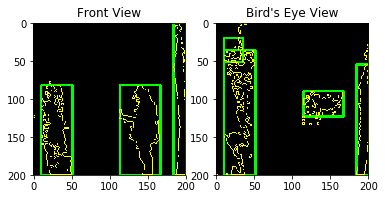

In [10]:
bin_smooth_xz = erode_dilate(bin_xz,1,2,1,2)
img_xz,boxes_xz = contour_boxes(bin_smooth_xz)
bin_smooth_xy = erode_dilate(bin_xy,1,2,1,2)
img_xy,boxes_xy = contour_boxes(bin_smooth_xy)

# Plot images with bounding boxes
fig, (ax1, ax2) = plt.subplots(1, 2)
# front view
ax1.imshow(img_xz)
ax1.set_title('Front View')

# bird's eye view
ax2.imshow(img_xy)
ax2.set_title("Bird's Eye View")

plt.show()

In [11]:
def find_y_range(boxes,x_cent):
    '''
    This function determines the approximate y range of the human obstacle
    
    Input:
    img: input bird's eye view image 
    boxes: bounding boxes in the image
    
    Output:
    y_new_range: tuple (ymin, ymax) y range we are inte
    '''
    # bounding boxes' distances from the center in x-direction 
    cent_dist = np.abs((boxes[:,2]-boxes[:,0])/2+boxes[:,0]-x_cent)
    # assume human obstacle is the one closest to the center
    human_idx = np.argmin(cent_dist)
    # get the range of y_values for the obstacle
    y_human = boxes[human_idx,3]-boxes[human_idx,1]
    # Approximate the human obstacle y_value range to be twice the perceived one (assume obstacle to be a cylindar)
    y_new_range = (int(boxes[human_idx,1]-0.1*y_human),int(boxes[human_idx,3]*2+0.1*y_human))
    return y_new_range
    

In [12]:
def calc_gap(boxes,x_cent):
    '''
    The function determines which side of the obstacle has bigger gap and also return the gap value in bin counts
    
    '''
    # bounding boxes' distances from the center in x-direction 
    cent_dist = np.abs((boxes[:,2]-boxes[:,0])/2+boxes[:,0]-x_cent)
    # assume human obstacle is the one closest to the center
    human_idx = np.argmin(cent_dist)
    # boxes that are on the left side of the obstacle
    left_boxes = boxes[boxes[:,0]<boxes[human_idx,0]]
    # boxes that are on the right side of the obstacle
    right_boxes = boxes[boxes[:,0]>boxes[human_idx,0]]
    
    # if there is no box on the left
    if left_boxes.size == 0:
        right_min = np.min(right_boxes[:,0])
        gap_right = right_min - boxes[human_idx,2]
        result = ['right',gap_right]
    
    # if there is no box on the right
    elif right_boxes.size == 0:
        left_max = np.max(left_boxes[:,2])
        gap_left = boxes[human_idx,0] - left_max
        result = ['left',gap_left]
    
    # general case
    else:
        # calculate the gap size on each side
        left_max = np.max(left_boxes[:,2])
        gap_left = boxes[human_idx,0] - left_max
        right_min = np.min(right_boxes[:,0])
        gap_right = right_min - boxes[human_idx,2]
    
        # store results 
        if gap_left > gap_right:
            result = ['left',gap_left]
        else:
            result = ['right',gap_right]
    return result

In [13]:
def BB_gap(X,Y,Z,binyz_s = 200,binx_s = 200):
    '''
    This function uses the coordinates in the world frame to determine the side with bigger gap and return the gap
    size in meters
    
    Input:
    X,Y,Z: world frame coordinates
    
    Keyword arguments: 
    binyz_s: # of bins in y or z direction
    binx_s: # of bins in x direction
    
    Output:
    result: a list shows the side ('left or right') with bigger gap and the gap size(meters)
    '''
    
    # First, find the y range of interest
    bin_xy = get_bin_img(-Y,X,binyz_s,binx_s) # get the bird's eye view binned image 
    # get the bounding boxes
    bin_smooth = erode_dilate(bin_xy,1,2,1,2)
    img,boxes = contour_boxes(bin_smooth)
    x_cent = int(img.shape[1]/2) # center on the x-axis
    # find the y_range of interest
    y_r = find_y_range(boxes,x_cent)
    
    # Calulate the gap based on the new image
    bin_new = bin_smooth[y_r[0]:y_r[1],:] # get the new binned image based on the y range
    img_new, boxes_new = contour_boxes(bin_new) # get the corresponding bounding boxes and image
    
    # Choose the side with bigger gap and return the gap size
    result = calc_gap(boxes,x_cent)
    result[1] = np.round(result[1] * (max(X) - min(X))/binx_s,2) #convert the gap size to meters
    return result

In [14]:
print(BB_gap(X,Y,Z))

['left', 0.71]


## Show result

In [15]:
def show_result(img_file):
    '''
    This function takes the input depth image txt file and returns the gap side and size
    '''
    depth_img = np.loadtxt(img_file)
    x,y,z = get_w_coords(depth_img)
    X,Y,Z = process_coords(x,y,z)
    result = BB_gap(X,Y,Z)
    #plt.imshow(depth_img)
    return result

In [16]:
img_file = 'human_corridor_0.txt'
result = show_result(img_file)
print(result[0],result[1])

left 0.71
